In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 256, 
                          "epochs": 30, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':1,
                          'workers':48,
                         'print_freq':2000,
                         'saved_dir':'../trained_models/stain_training_stomach/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

3
cuda:1


In [5]:
from augment import *

# stain_mat = np.array([[ 0.63854984,  0.25636421, -0.05117216],
#  [ 0.72885336,  0.89928835,  0.35397438],
#  [ 0.24388358,  0.33553481, -0.92226462]])

# stain_mat = np.array([[ 0.48333748, -0.87457766,  0.03871443],
#        [ 0.81212054,  0.46445478,  0.35318832],
#        [ 0.32687172,  0.13926837, -0.93475088]])

stain_mat = np.array([[ 0.53420104, -0.8391861 , -0.08528147],
       [ 0.79607249,  0.46660234,  0.38413706],
       [ 0.28257426,  0.27306047, -0.91785066]])

def HEColor_augment(img, sigma1=0.1, sigma2=1):
    
#     _, StainsFloat, stain_mat  = color_deconvolution_routine(img)
    inv_mat = LA.inv(stain_mat)

#     conversion to Stain & eosin domain
#     od_img = convert_RGB_to_OD(img)
    sda_img = rgb_to_sda(img)
    conv_img = np.matmul(sda_img, inv_mat.T)
    
    '''
        .. [#] Tellez, David, Geert Litjens, Peter Bandi, Wouter Bulten,
               John-Melle Bokhorst, Francesco Ciompi, and Jeroen van der Laak.
               "Quantifying the effects of data augmentation and stain color
               normalization in convolutional neural networks for computational
               pathology." arXiv preprint arXiv:1902.06543 (2019).
    '''
#     remove scale and add more bias for main axis, axis ratio is about 20 : 2 : 1
    for i in range(conv_img.shape[-1]) :
        if i == 0 :
            alpha = np.random.uniform(1-sigma1, 1+sigma1)
#         beta = np.random.uniform(-sigma2, sigma2)
            beta = np.random.normal(0, sigma2)   
        elif i == 1 :
            alpha = 1
            beta = np.random.normal(0, sigma2)   
        elif i == 2 :
            alpha = 1
            beta = np.random.normal(0, sigma2*0.5)
#         conv_img[:,:,i] *= alpha
        conv_img[:,:,i] *= alpha
        conv_img[:,:,i] += beta
        
    aug_img = np.matmul(conv_img, stain_mat.T)
#     aug_img = convert_OD_to_RGB(aug_img)
    aug_img = sda_to_rgb(aug_img)
    
    return np.clip(aug_img, 0, 255)

class HEColorAugment(ImageOnlyTransform) :    
    def __init__(
        self,
        sigma1=0.1,
        sigma2=3.,
        always_apply=False,
        p=1.,
 ):
        super(HEColorAugment, self).__init__(always_apply, p)
        self.sigma1= sigma1
        self.sigma2= sigma2
        
    def apply(self, img,  **params):
        return HEColor_augment(img, self.sigma1, self.sigma2)

In [6]:
IMAGE_SIZE = 256
from augment import HEColorAugment
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.7),
        A.VerticalFlip(p=.7),
        A.RandomRotate90(p=.7)]
    ),
#     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
#     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
    HEColorAugment(sigma1=0.2, sigma2=1., p=0.8),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2
from augment import HEColorAugment, rgb_to_sda

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
            
#         image = rgb_to_sda(image)
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
train_dataset = CDataset(train_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/', 
                         transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Stomach_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Stomach_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                        transform=val_transforms)  

In [9]:
image, label, path = next(iter(train_dataset))
# image

In [10]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
images, labels, paths = next(iter(train_loader))
images.shape

torch.Size([256, 3, 256, 256])

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)
default_state_dict = model.state_dict()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [13]:
from main import *

In [14]:
ratio = [0, .02, .04, .06, .08, .1]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet/stain_4_' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
    args.ratio = ratio[num]
    
    if num == 0 :
        train_transforms = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.OneOf([
                A.HorizontalFlip(p=.7),
                A.VerticalFlip(p=.7),
                A.RandomRotate90(p=.7)]
            ),
        #     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
#             HEColorAugment(sigma1=args.ratio, sigma2=2., p=0.7),
        ], p=1.0)
    else :
        train_transforms = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.OneOf([
                A.HorizontalFlip(p=.7),
                A.VerticalFlip(p=.7),
                A.RandomRotate90(p=.7)]
            ),
        #     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
            HEColorAugment(sigma1=args.ratio, sigma2=2, p=0.7),
        ], p=1.0)        
    
    model = models.resnet18(pretrained=True)
    # model.fc.out_features = 3
    model.fc = nn.Linear(512, 3)
    model.load_state_dict(default_state_dict)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
    optimizer = torch.optim.SGD(
           params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
        print('lr', optimizer.param_groups[0]['lr'])
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

lr 0.1
Epoch: [0][  0/297]	Time 51.554 (51.554)	Data 49.563 (49.563)	Loss 1.2419e+00 (1.2419e+00)	Acc@1  28.91 ( 28.91)
Test: [  0/102]	Time  5.107 ( 5.107)	Loss 1.4437e+00 (1.4437e+00)	Acc@1  38.28 ( 38.28)
 * Acc@1 36.154
lr 0.1
Epoch: [1][  0/297]	Time 52.779 (52.779)	Data 52.427 (52.427)	Loss 8.3326e-01 (8.3326e-01)	Acc@1  61.33 ( 61.33)
Test: [  0/102]	Time  6.144 ( 6.144)	Loss 9.9657e+01 (9.9657e+01)	Acc@1  30.08 ( 30.08)
 * Acc@1 25.565
lr 0.1
Epoch: [2][  0/297]	Time 51.614 (51.614)	Data 51.240 (51.240)	Loss 1.1391e+00 (1.1391e+00)	Acc@1  49.22 ( 49.22)
Test: [  0/102]	Time  5.485 ( 5.485)	Loss 1.5589e+00 (1.5589e+00)	Acc@1  41.80 ( 41.80)
 * Acc@1 40.784
lr 0.1
Epoch: [3][  0/297]	Time 52.135 (52.135)	Data 51.821 (51.821)	Loss 9.5541e-01 (9.5541e-01)	Acc@1  54.30 ( 54.30)
Test: [  0/102]	Time  5.902 ( 5.902)	Loss 1.2163e+00 (1.2163e+00)	Acc@1  59.38 ( 59.38)
 * Acc@1 62.216
lr 0.1
Epoch: [4][  0/297]	Time 52.111 (52.111)	Data 51.701 (51.701)	Loss 8.3118e-01 (8.3118e-01)	Acc@1 

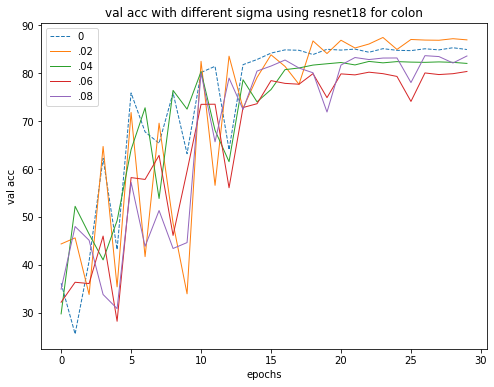

[tensor(87.2280, device='cuda:1'), tensor(89.0800, device='cuda:1'), tensor(85.7861, device='cuda:1'), tensor(83.5637, device='cuda:1'), tensor(86.1763, device='cuda:1'), tensor(85.1710, device='cuda:1')]


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['lines.linewidth'] = 1
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
plt.plot(epochs, acc_list[3])
plt.plot(epochs, acc_list[4])
plt.legend(['0', '.02', '.04', '.06', '.08', .1])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with different sigma using resnet18 for colon')
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)

In [16]:
ratio 

[0, 0.02, 0.04, 0.06, 0.08, 0.1]